## Importing Required Libraries

## Extracting Files

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
c = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
n = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
p = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [3]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 2500) + os.listdir(p)

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID

In [4]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [5]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,2
1,../input/covid19-radiography-database/COVID-19...,2
2,../input/covid19-radiography-database/COVID-19...,2
3,../input/covid19-radiography-database/COVID-19...,2
4,../input/covid19-radiography-database/COVID-19...,2


In [7]:
df.shape

(7461, 2)

## Exploratory Data Analysis

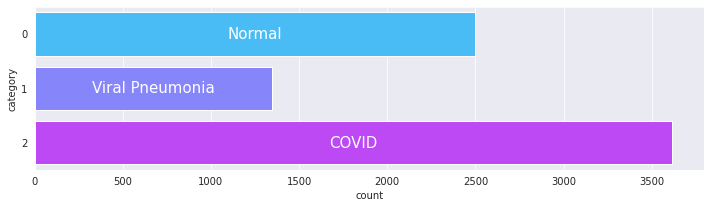

In [8]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Viral Pneumonia', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

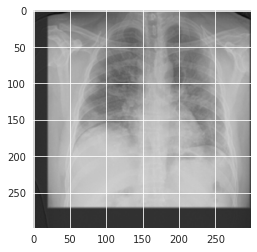

In [9]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [10]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [11]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [13]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [14]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [15]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


In [16]:
engine = tf.keras.applications.VGG16(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),

    )
    
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

2023-02-18 06:36:48.862549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 06:36:48.964701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 06:36:48.965482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 06:36:48.966737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [27]:
 history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=50,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

Epoch 1/50
187/187 [==============================] - 89s 475ms/step - loss: 0.5940 - accuracy: 0.7346 - val_loss: 0.5218 - val_accuracy: 0.7711
Epoch 2/50
187/187 [==============================] - 89s 476ms/step - loss: 0.5778 - accuracy: 0.7410 - val_loss: 0.4890 - val_accuracy: 0.7992
Epoch 3/50
187/187 [==============================] - 90s 480ms/step - loss: 0.5792 - accuracy: 0.7448 - val_loss: 0.5759 - val_accuracy: 0.7282
Epoch 4/50
187/187 [==============================] - 90s 480ms/step - loss: 0.5522 - accuracy: 0.7596 - val_loss: 0.4794 - val_accuracy: 0.8005
Epoch 5/50
187/187 [==============================] - 89s 478ms/step - loss: 0.5403 - accuracy: 0.7683 - val_loss: 0.4731 - val_accuracy: 0.8072
Epoch 6/50
187/187 [==============================] - 89s 477ms/step - loss: 0.6206 - accuracy: 0.7188 - val_loss: 3.2300 - val_accuracy: 0.5582
Epoch 7/50
187/187 [==============================] - 91s 486ms/step - loss: 0.5995 - accuracy: 0.7376 - val_loss: 0.4688 - val_ac

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

#### Model Architecture

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Final Test

In [28]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [29]:
 model.evaluate(test_set)

24/24 [==============================] - 3s 113ms/step - loss: 0.4460 - accuracy: 0.8164


[0.4459768235683441, 0.8163539171218872]

In [30]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID'], digits=2))



                 precision    recall  f1-score   support

         Normal       0.82      0.63      0.71       250
Viral Pneumonia       0.88      0.89      0.88       134
          COVID       0.80      0.92      0.85       362

       accuracy                           0.82       746
      macro avg       0.83      0.81      0.82       746
   weighted avg       0.82      0.82      0.81       746



## Saving Model

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_set.labels,predIdxs )

array([[157,  17,  76],
       [  6, 119,   9],
       [ 29,   0, 333]])

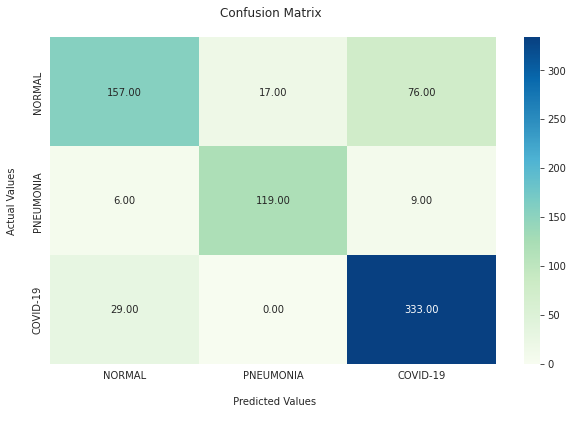

In [32]:
plt.figure(figsize=(10,6))
import seaborn as sns
fx= sns.heatmap(confusion_matrix(test_set.labels,predIdxs), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['NORMAL','PNEUMONIA','COVID-19'])
fx.yaxis.set_ticklabels(['NORMAL','PNEUMONIA','COVID-19'])
plt.show()

In [66]:
model.save('Covid.h5')

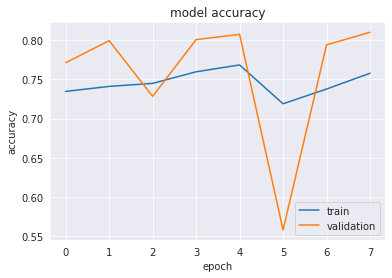

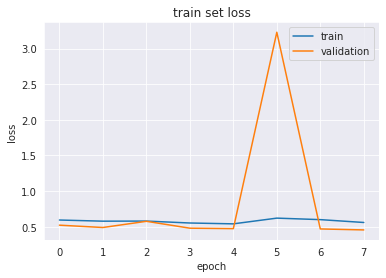

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Model Testing

In [35]:
loss, accuracy = model.evaluate(valid_generator)

24/24 [==============================] - 3s 110ms/step - loss: 0.4551 - accuracy: 0.8099
